In [1]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 4 - Fall 2025
## Due 11:59 PM, Tue 4 Nov, 2025

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

**Introduction:** In this assignment, we will compare a dimensionalized, Barnes-style weight function to the Gaussian function in `scipy.signal.windows.gaussian`. We understand its nondimensional frequency response quite well using theory from Koch, Trapp and Doswell, etc. However, the functions in `scipy.signal.windows.gaussian` control the cutoff in terms of the standard deviation. Since the functions are mathmatically equivalent, we should be able to reconcile them.

Then, we will calculate the response functions of various other weight functions and compare them to one another.


**1.** Fourier transforms of data.

**a.** Using a data spacing of $\Delta=10$ m, what is the nyquist length scale $L_n$, and the spatial sampling frequency $f_s$ and nyquist $f_n$? Calculate these quantities in code from what is given, don't just fill in the values.


In [2]:
delta = 10.0
Ln = 2*delta
fs = 1.0/delta
fn = fs/2.0  #fn= 1/2delta
print("Nyquist Length Scale Ln=", Ln, "Sampling Frequency fs=", fs, "Nyquist Frequency fn=", fn, "1/Ln=", 1.0/Ln)

Nyquist Length Scale Ln= 20.0 Sampling Frequency fs= 0.1 Nyquist Frequency fn= 0.05 1/Ln= 0.05


Let's assume we have $N=2048$ samples of data and sample at evenly spaced locations $x$ from $0$ to $(N-1)\Delta$.

To get a feel for what data looks like in the frequncy domain transform, let's look at a step function, a linear ramp, and a sine wave. The function provided below calcualtes the Fourier transform and plots its amplitude and phase response. You'll use this style of plot (and the function that makes it) for the rest of the assignment.

**b.** There is no waviness to the ramp. Why is there amplitude at so many frequencies? 

**c.** When you run the code to show the FFT of the sine wave, why is there amplitude at more than a single frequency?

0.0 20460.0
4.885197850512946e-05 4.885197850512946e-05
-0.04997557401074744 0.04997557401074744 0.05
-20470.0 20470.0


C:\Users\melmo\AppData\Local\Temp\ipykernel_25616\3170128013.py:25: RuntimeWarning: divide by zero encountered in divide
  freqs = 1.0/freq
C:\Users\melmo\AppData\Local\Temp\ipykernel_25616\3170128013.py:36: RuntimeWarning: divide by zero encountered in divide
  fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
C:\Users\melmo\AppData\Local\Temp\ipykernel_25616\3170128013.py:36: RuntimeWarning: invalid value encountered in divide
  fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])


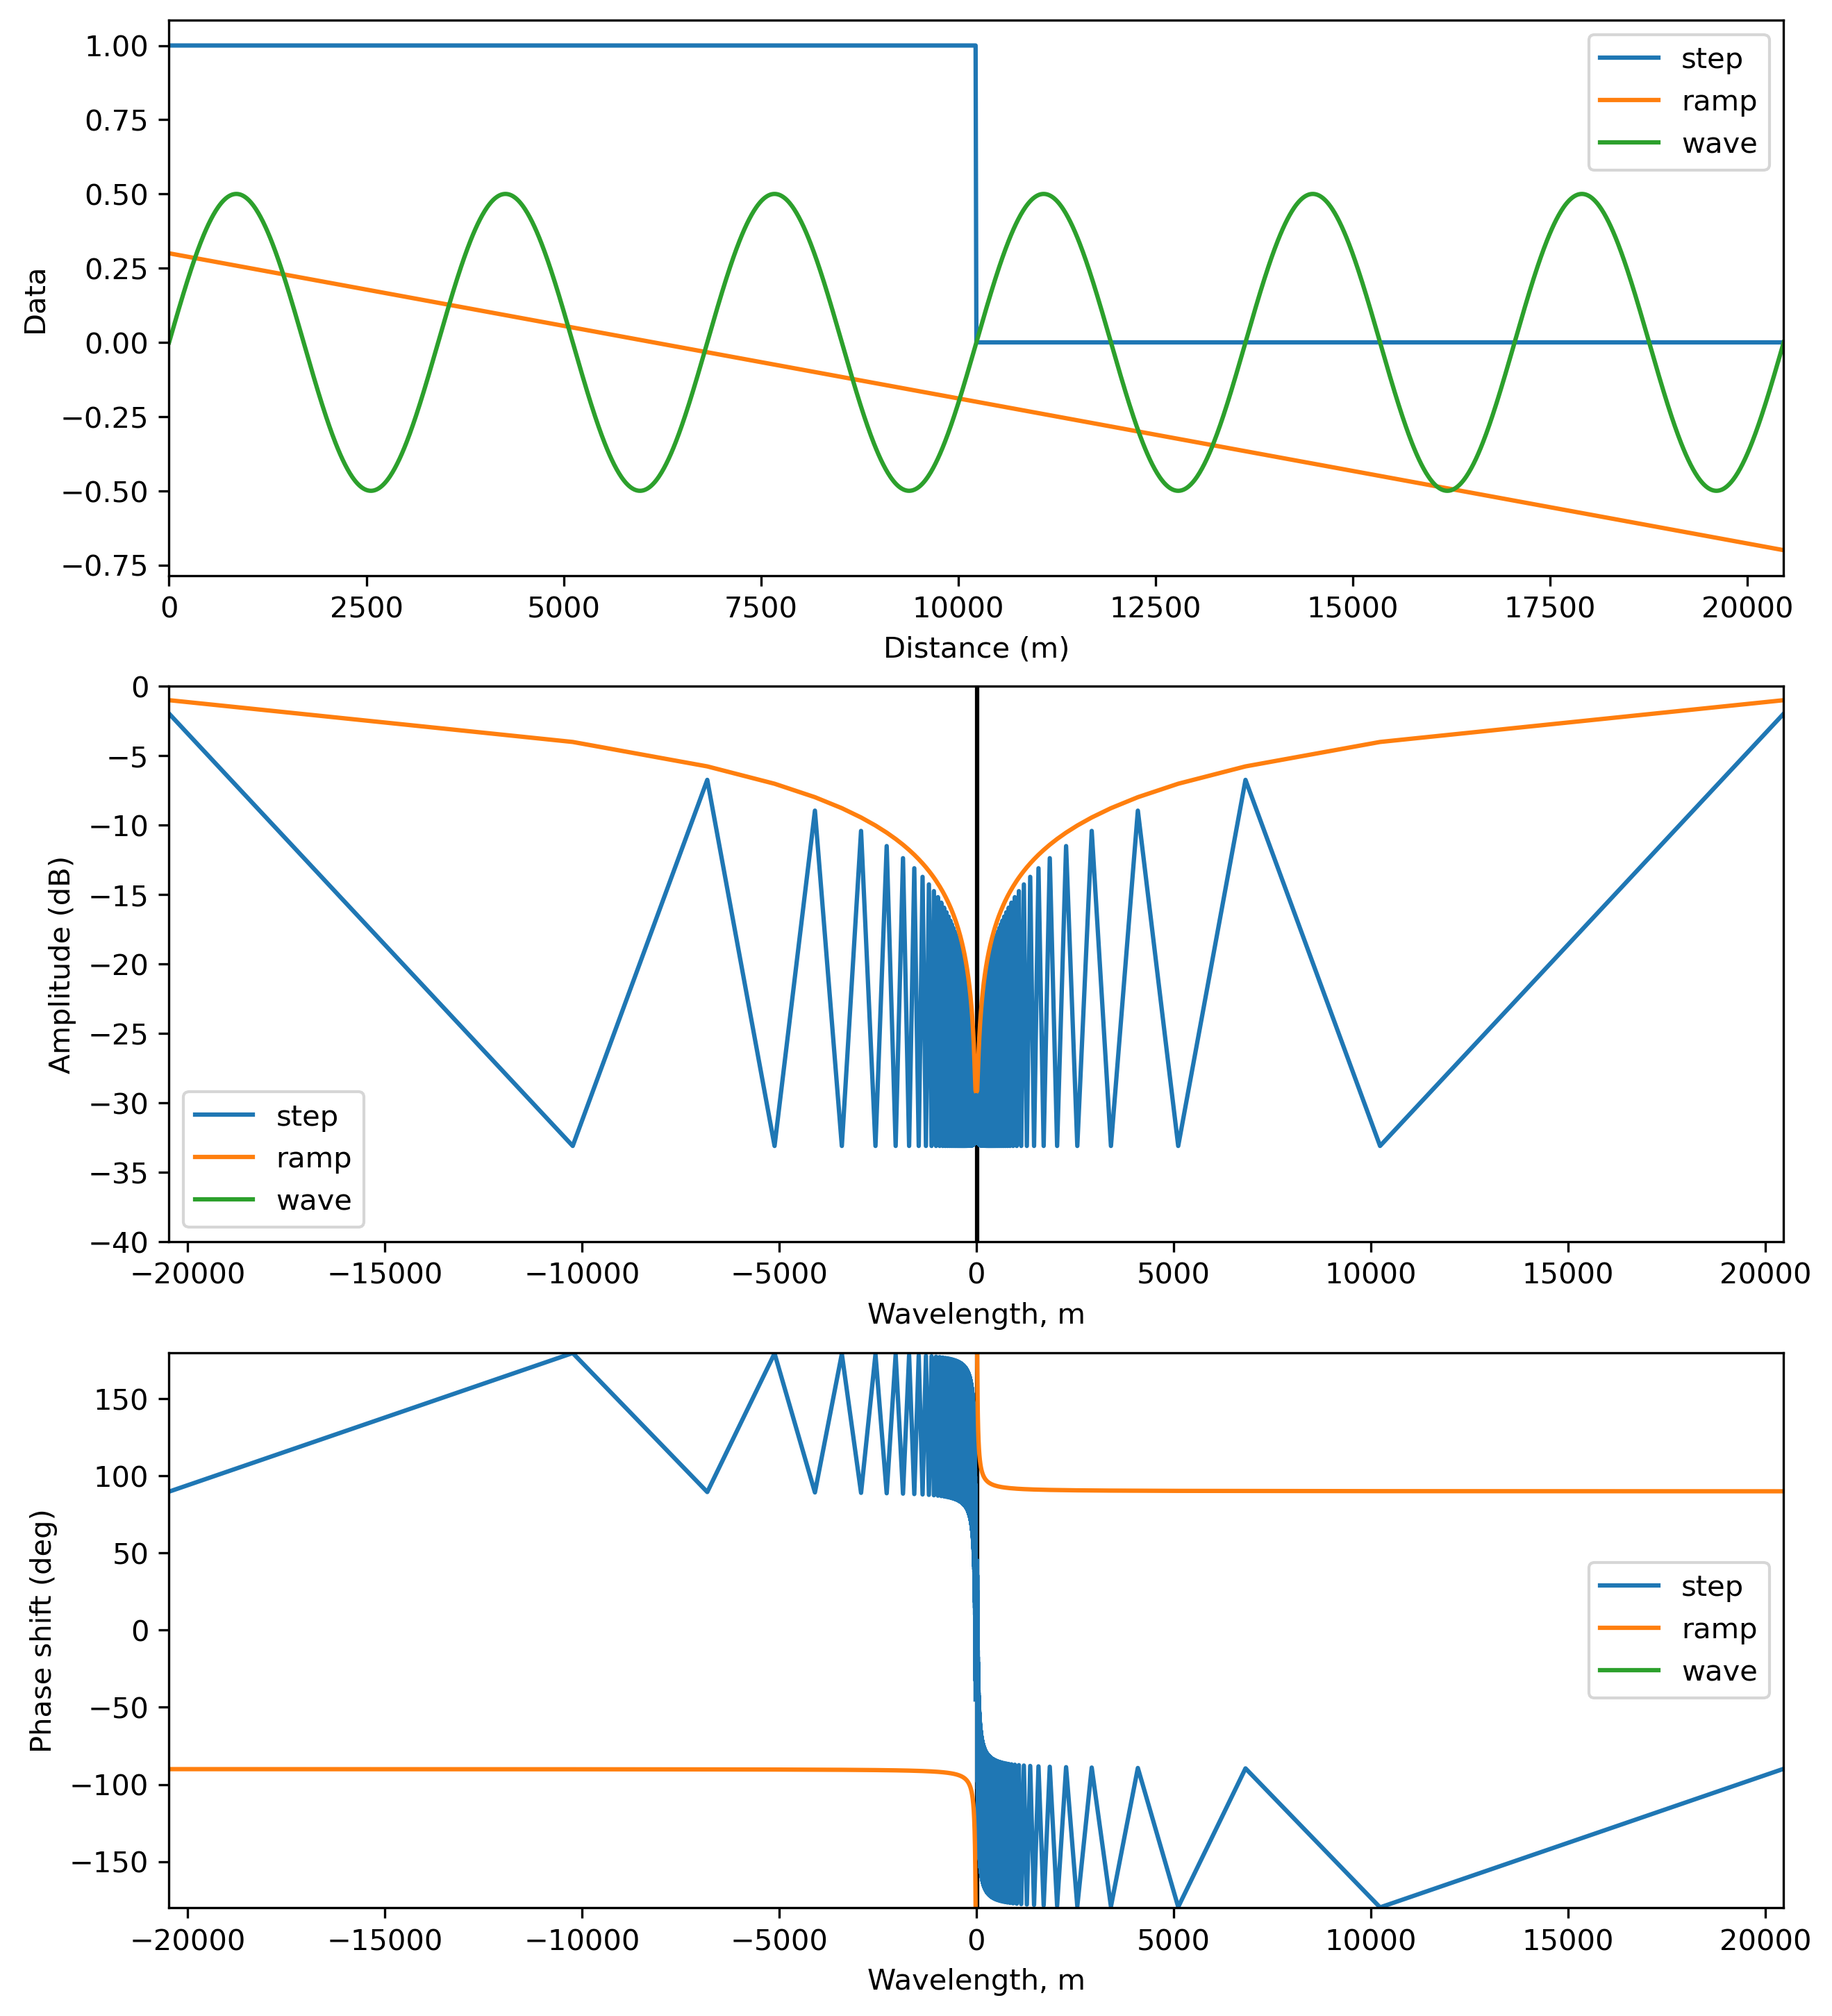

In [3]:
N = 2047
x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

b. The ramp is a non-periodic function where it decomposes into the components of the sinusoidal frequencies, with a linear look about it. Fourier analysis expresses functions as a sum of periodic components and recoveres the signal from those components. FFT assumes the data repeats periodically, that ramps decay with increasing frequency, and that energy is present at all frequencies. Therefore, the lack of waviness to the ramp shows a smooth signal made up of sinusoidal components. 

c. We see the sine wave having amplitude at multiple frequencies due to the basic fact that sinusoidal sine functions naturally produce two FFT peaks at fo and -fo. We also know that FFT shows frequencies in bins with the fundamental frequency $Deltaf$, so if the waveform has an integer number of cycles then the plot will line up with the bins and have sharp peaks.

**2.** 

**a.** Implment the Barnes distance-dependent weighting function for $\kappa^* = 0.1$ and $0.5$. Center the weight function in the middle of the time series.

**b.** Simulate an artificial cutoff radius by setting any weights with value less than 0.1 to zero. This will give you four weight functions, two for each $\kappa^*$.

**c.** Use the `response_plot` function provided above to plot the four weight functions and their frequency domain response. Plot in wavelength mode (using the keyword argument to the plotting function), and zoom in to distances and wavelengths between 0 and 20 (you don't need to show the negative wavelengths). Do not duplicate the response plot function or otherwise modify it. You can zoom the plot outside the function by using the `axes` variable.

-0.04997557401074744 0.04997557401074744


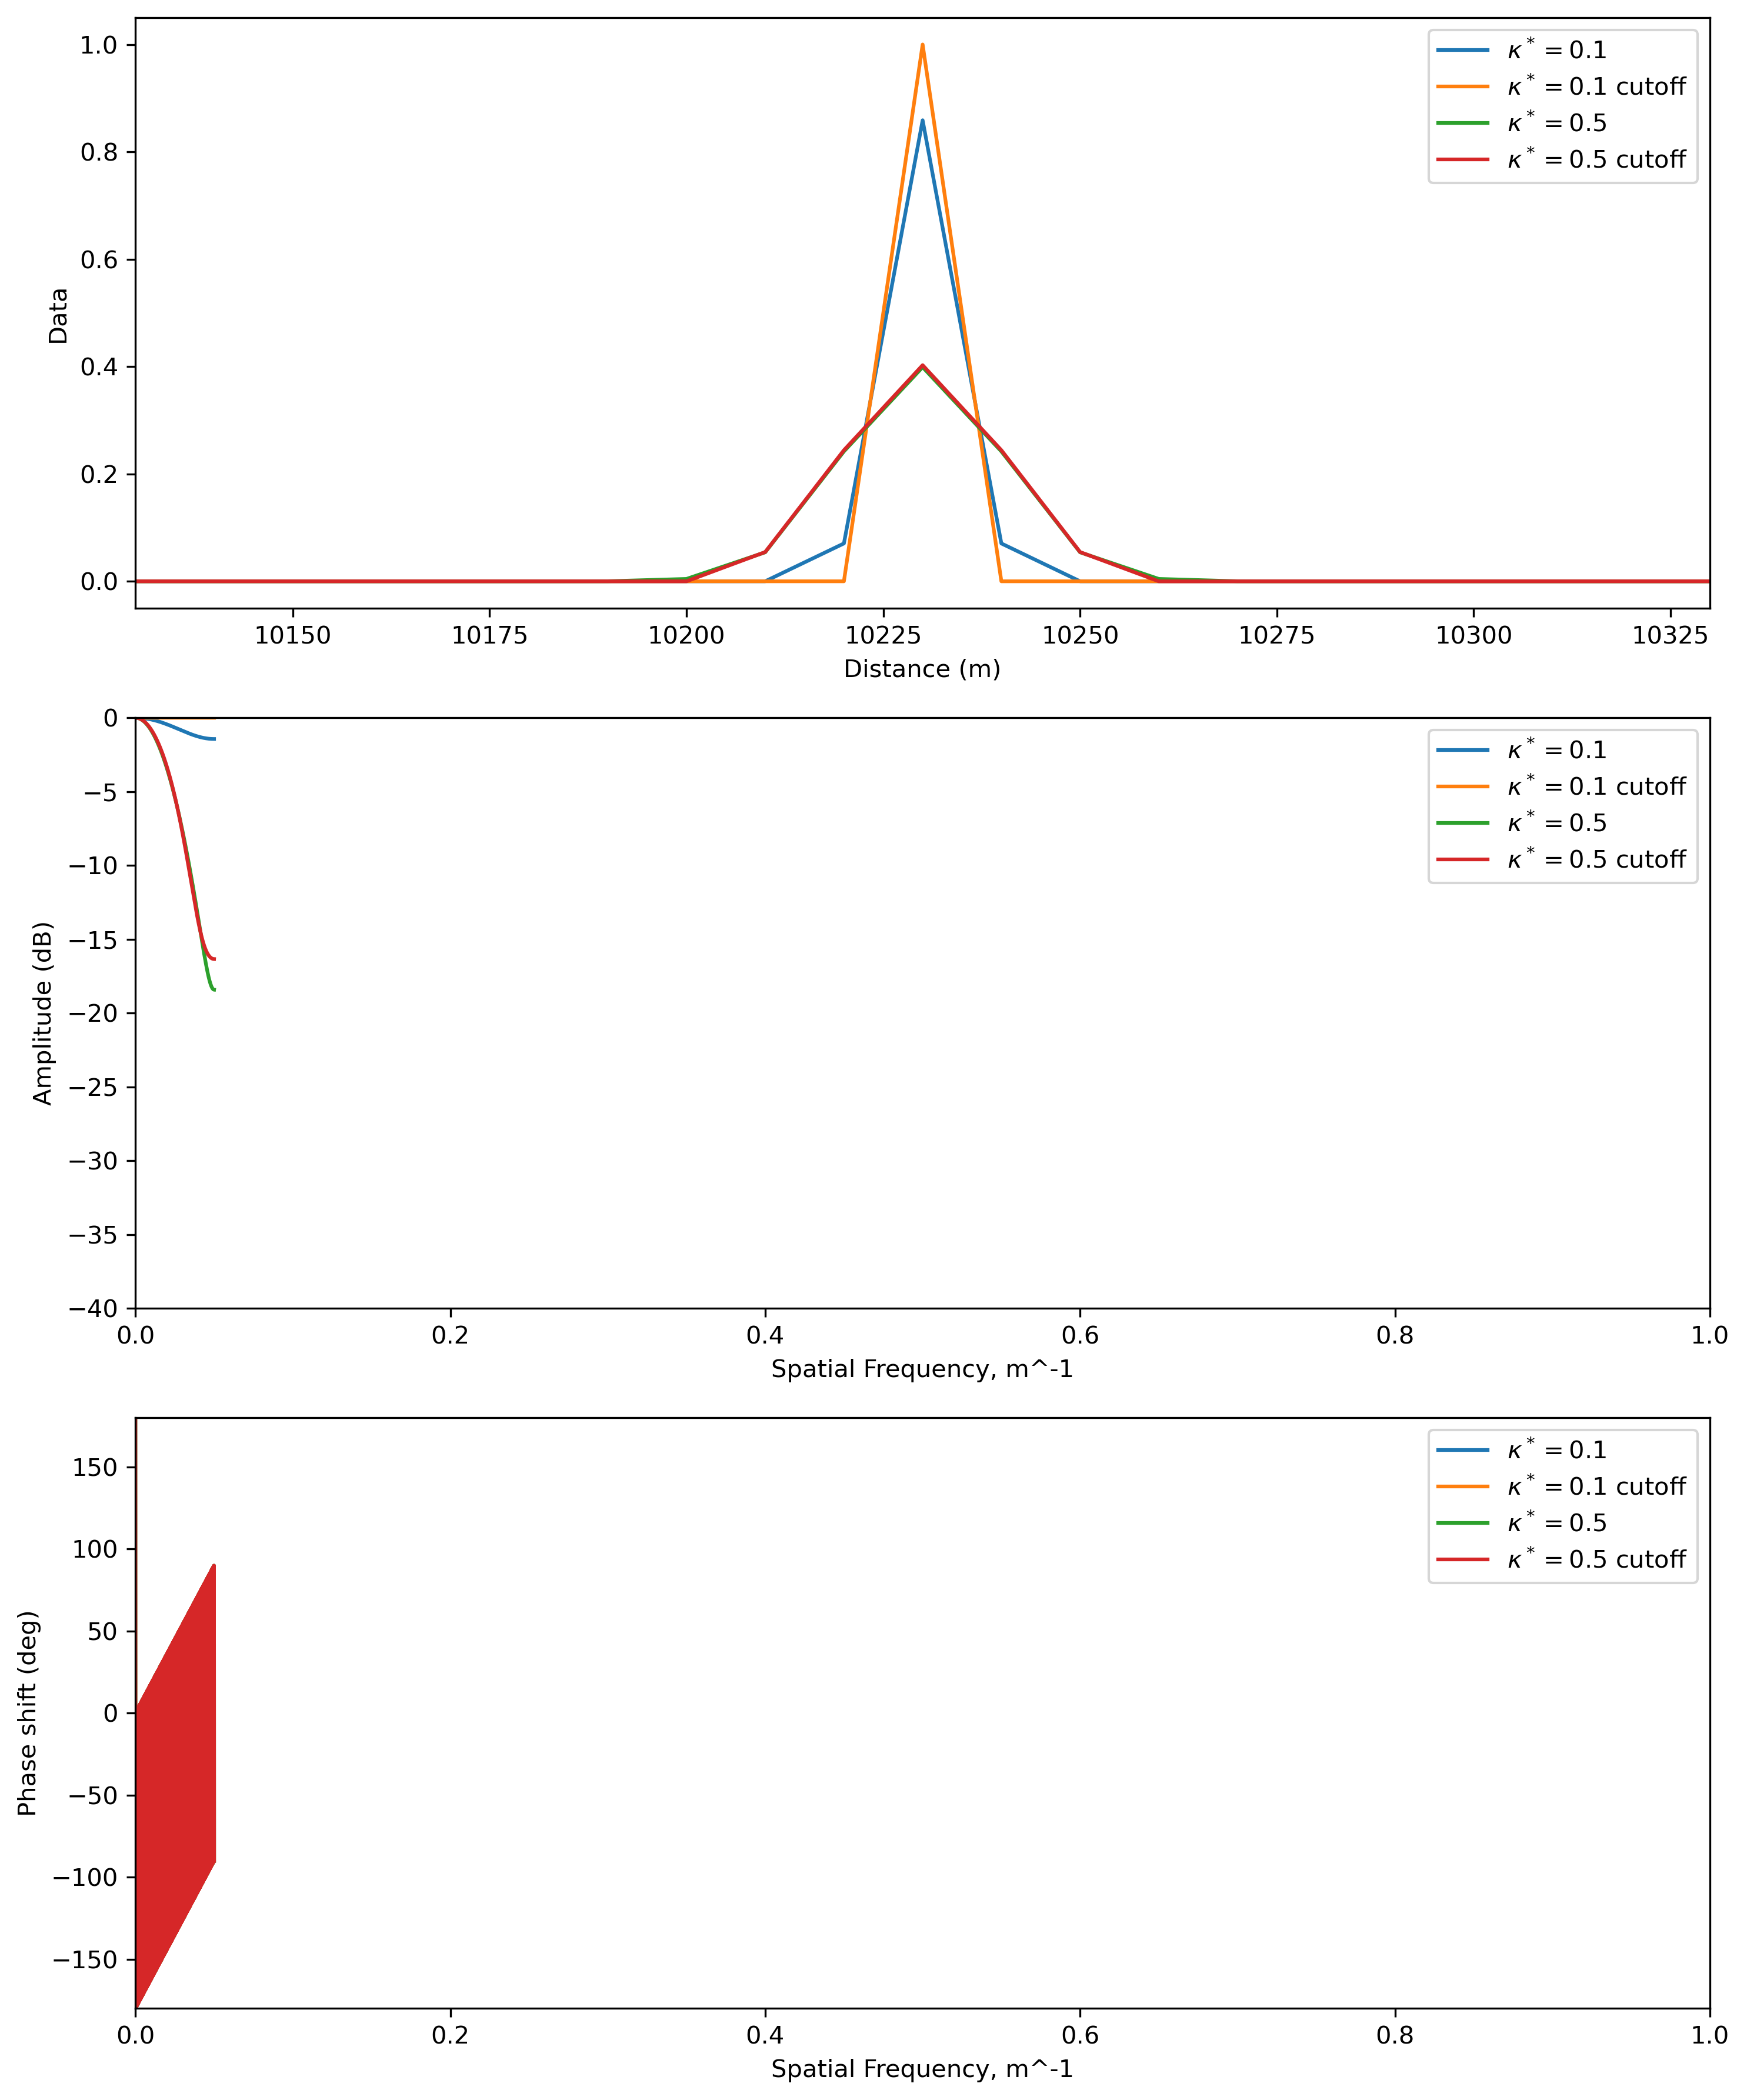

In [4]:
#a. Center weight function given k*
def barnes(r, k):
    """ r has units of distance, and k is the dimensional weight parameter
        kappa with units of distance squared.
        
        Returns the weights as a funcion of r.
    """
    #Barnes w(r)= e^(-r^2/k)
    # k= k*Ln^2
    return np.exp(-(r**2)/k)

# Center function in middle of domain
r= (x-x.mean())

from scipy.signal.windows import gaussian

# b. 4 weight functions, k*= 0.1 and k= 40, k*= 0.5 and k= 200
kappa= [0.1, 0.5]
barnes_weights= []

for ks in kappa:
    k= ks*Ln**2
    w= barnes(r,k)
    w_cutoff= np.where(w< 0.1, 0.0, w) #cutoff rad
    barnes_weights.append((w, w_cutoff))
    
# c. Plot functions and freq domain response in wavelength mode
# Flatten tuples
all_weights= [item for pair in barnes_weights for item in pair] 

# Normalize
all_weights= [w/w.sum() if w.sum() !=0 else w for w in all_weights]

barnes_w01, barnes_w01_cut, barnes_w05, barnes_w05_cut= all_weights

labels= [r'$\kappa^*= 0.1$', r'$\kappa^*= 0.1$ cutoff', 
         r'$\kappa^*= 0.5$', r'$\kappa^*= 0.5$ cutoff']

# Plots
fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)
response_plot(all_weights, x, axes, freqs, labels= labels, wavelength= False)

#zooming into distances and wavelengths from 0-20
axes[0].set_xlim(x.mean()-100, x.mean()+100)
axes[1].set_xlim(0, 1)
axes[2].set_xlim(0, 1)
plt.tight_layout()
plt.show()

In [5]:
# Quick test of weight's FFT 
w_test = all_weights[0]
fft_test = np.fft.fft(w_test)
amp = np.abs(np.fft.fftshift(fft_test))
print("amp max:", amp.max(), "min:", amp.min(), "any NaNs:", np.any(~np.isfinite(amp)))

amp max: 1.0000000000000002 min: 0.7179843184810946 any NaNs: False


**3.** Instead of weighting with the distance dependent weighting function you wrote, let's use the built-in Gaussian function: `from scipy.signal.windows import gaussian`. It is formulated in terms of the standard deviation. In lecture we derived the relationship $\sigma = \sqrt{2\kappa^*}$. 

Reproduce your plot above using the built-in Gaussian window (weight) function.

-0.04997557401074744 0.04997557401074744


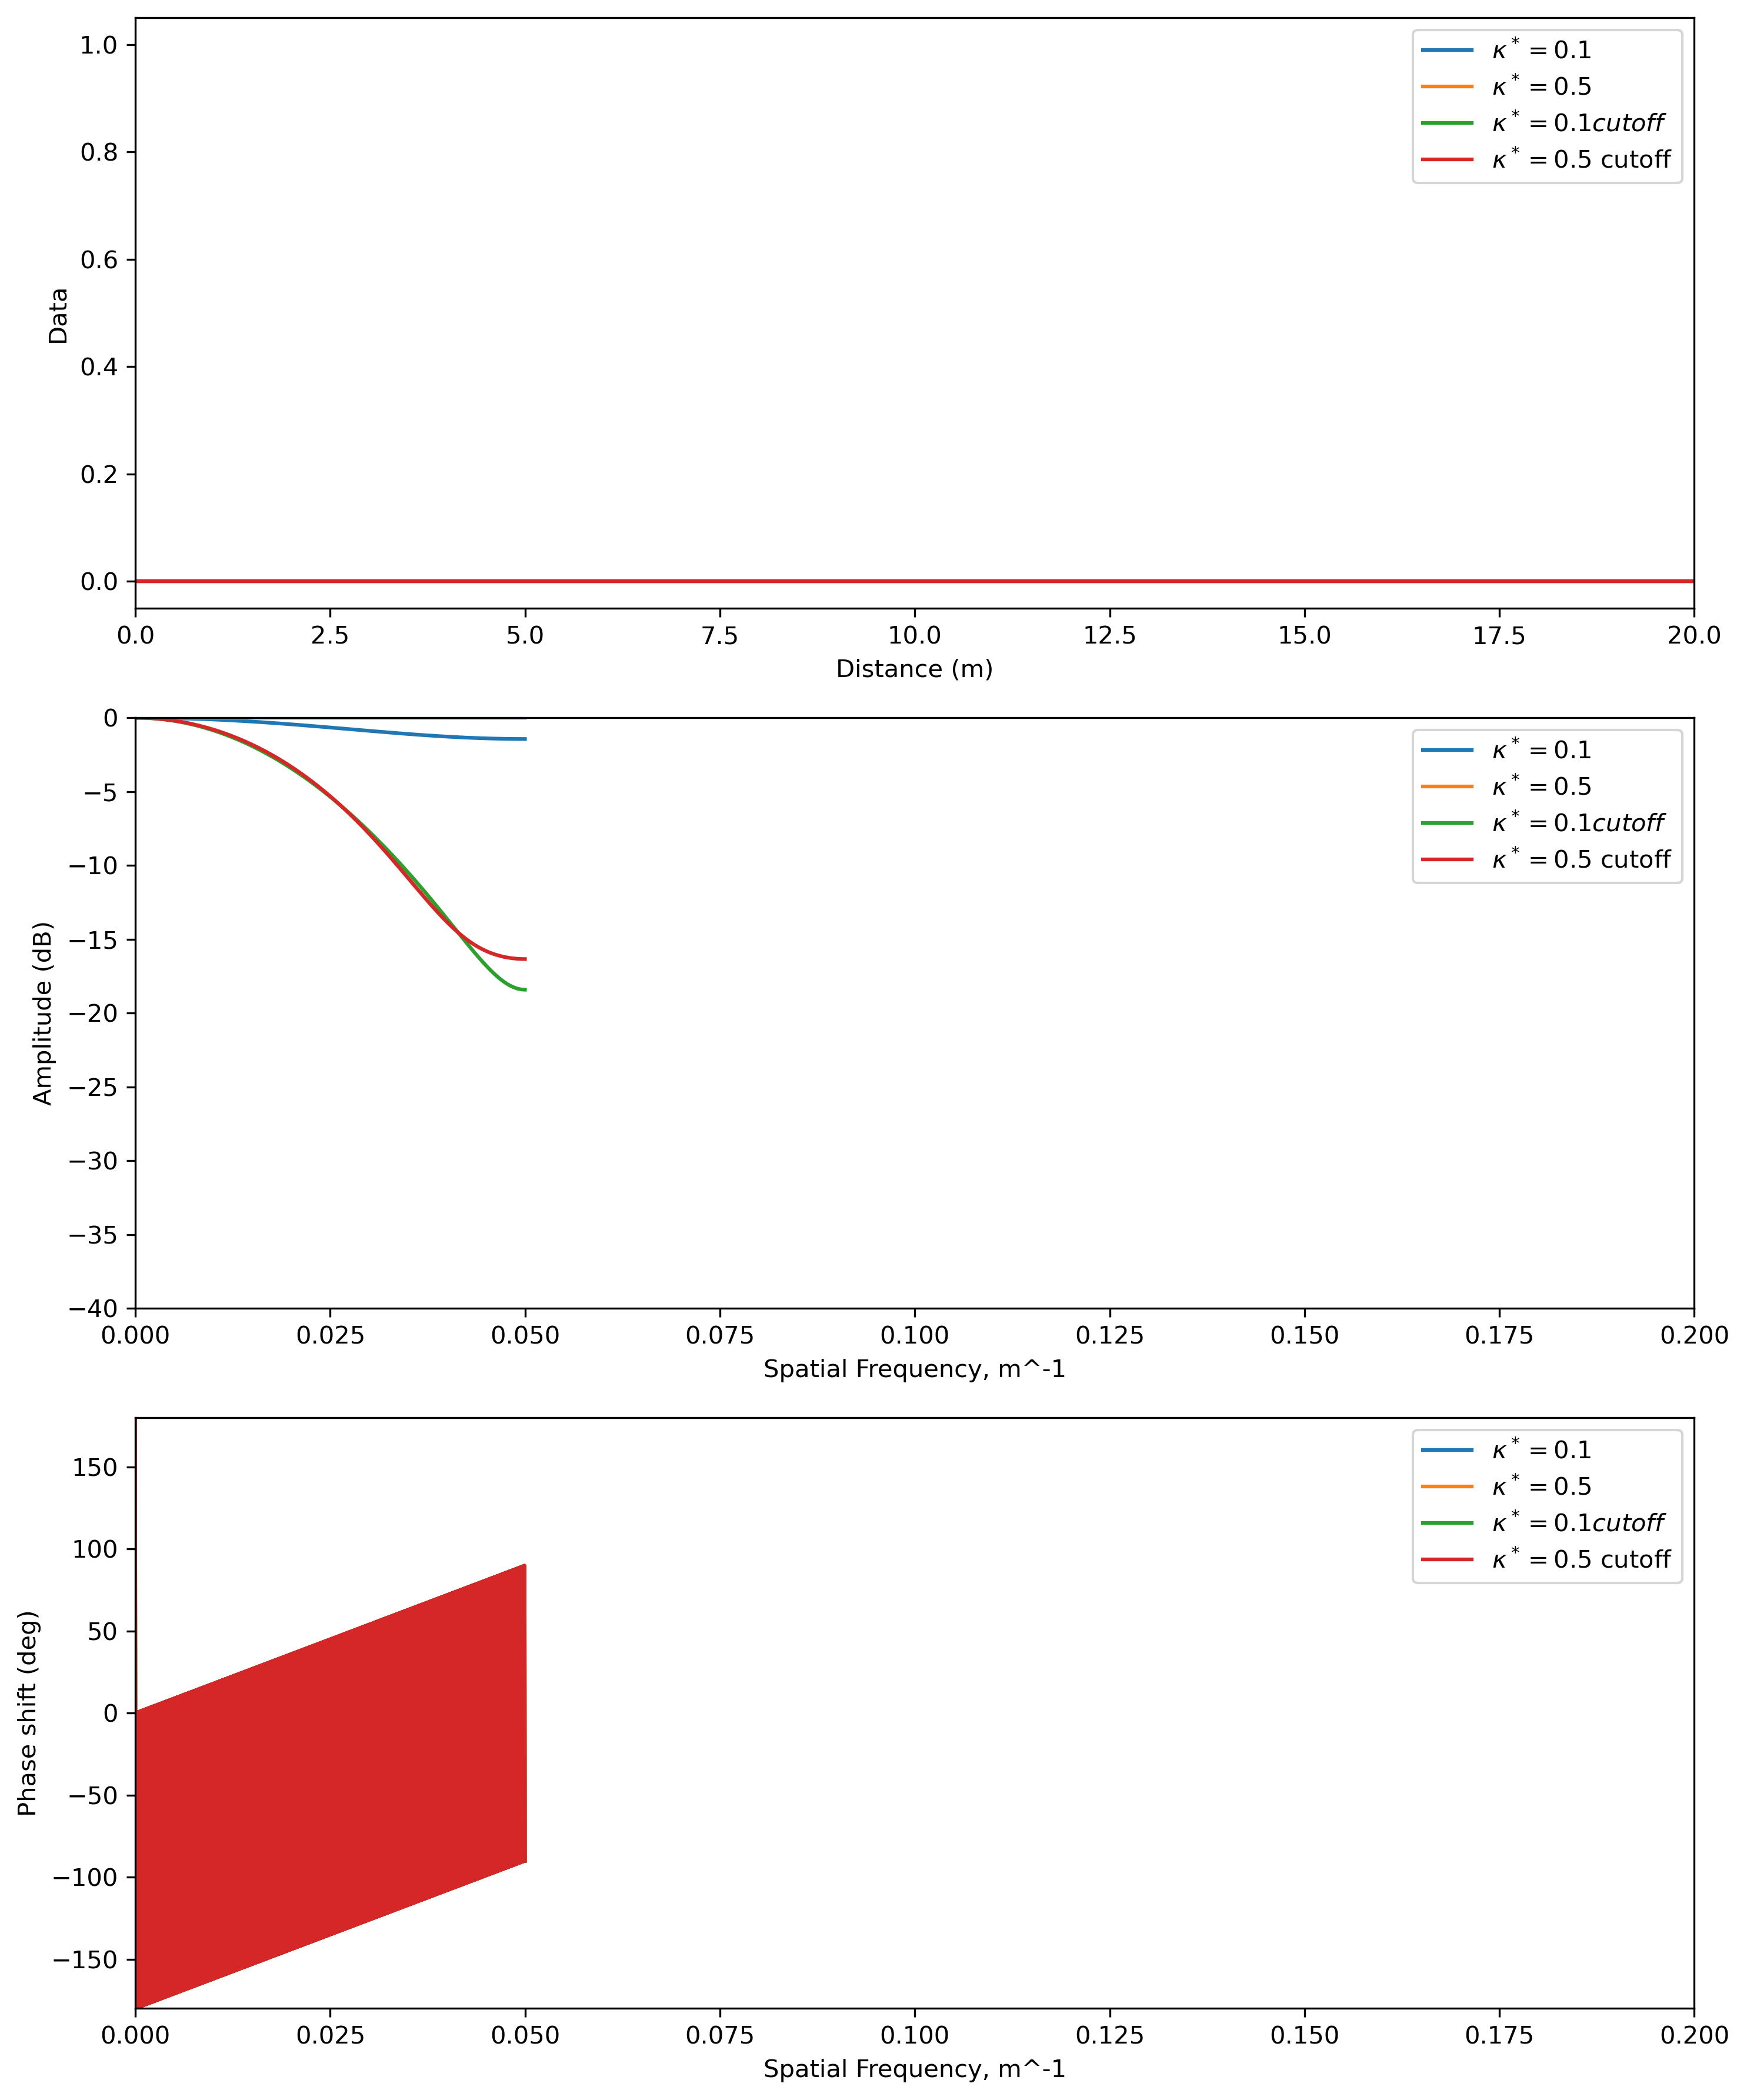

In [6]:
from scipy.signal.windows import gaussian

# Given param
sigma_vals=[np.sqrt(2*k) for k in kappa] # distance

# std
sigma_samples= [s/delta for s in sigma_vals]

# Gaussian windows 
gauss_weights= [gaussian(N, std= s) for s in sigma_samples]

# Cutoff
gauss_cutoff= [np.where(w< 0.1, 0, w) for w in gauss_weights]

# combining all 4 weight functs
all_weights= [w/w.sum() for w in all_weights]

gauss_w01, gauss_w01_cut, gauss_w05, gauss_w05_cut= all_weights

# Labels
labels= [r'$\kappa^* =0.1$', r'$\kappa^* =0.5$',
         r'$\kappa^* =0.1 cutoff$', r'$\kappa^* =0.5$ cutoff']

# Plotting
fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)

response_plot(all_weights, x, axes, freqs, labels= labels, wavelength= False)

# Zooming in 0–20m on wavelength and distance axes
axes[0].set_xlim(0, 20)    # Data axis (distance)
axes[1].set_xlim(0, 0.2)   # Frequency axis (amplitude)
axes[2].set_xlim(0, 0.2)   # Frequency axis (phase)
plt.tight_layout()

**4.** Implement and plot the frequency response for 3- and 5-point rectangular weight (boxcar) functions.

-0.04997557401074744 0.04997557401074744


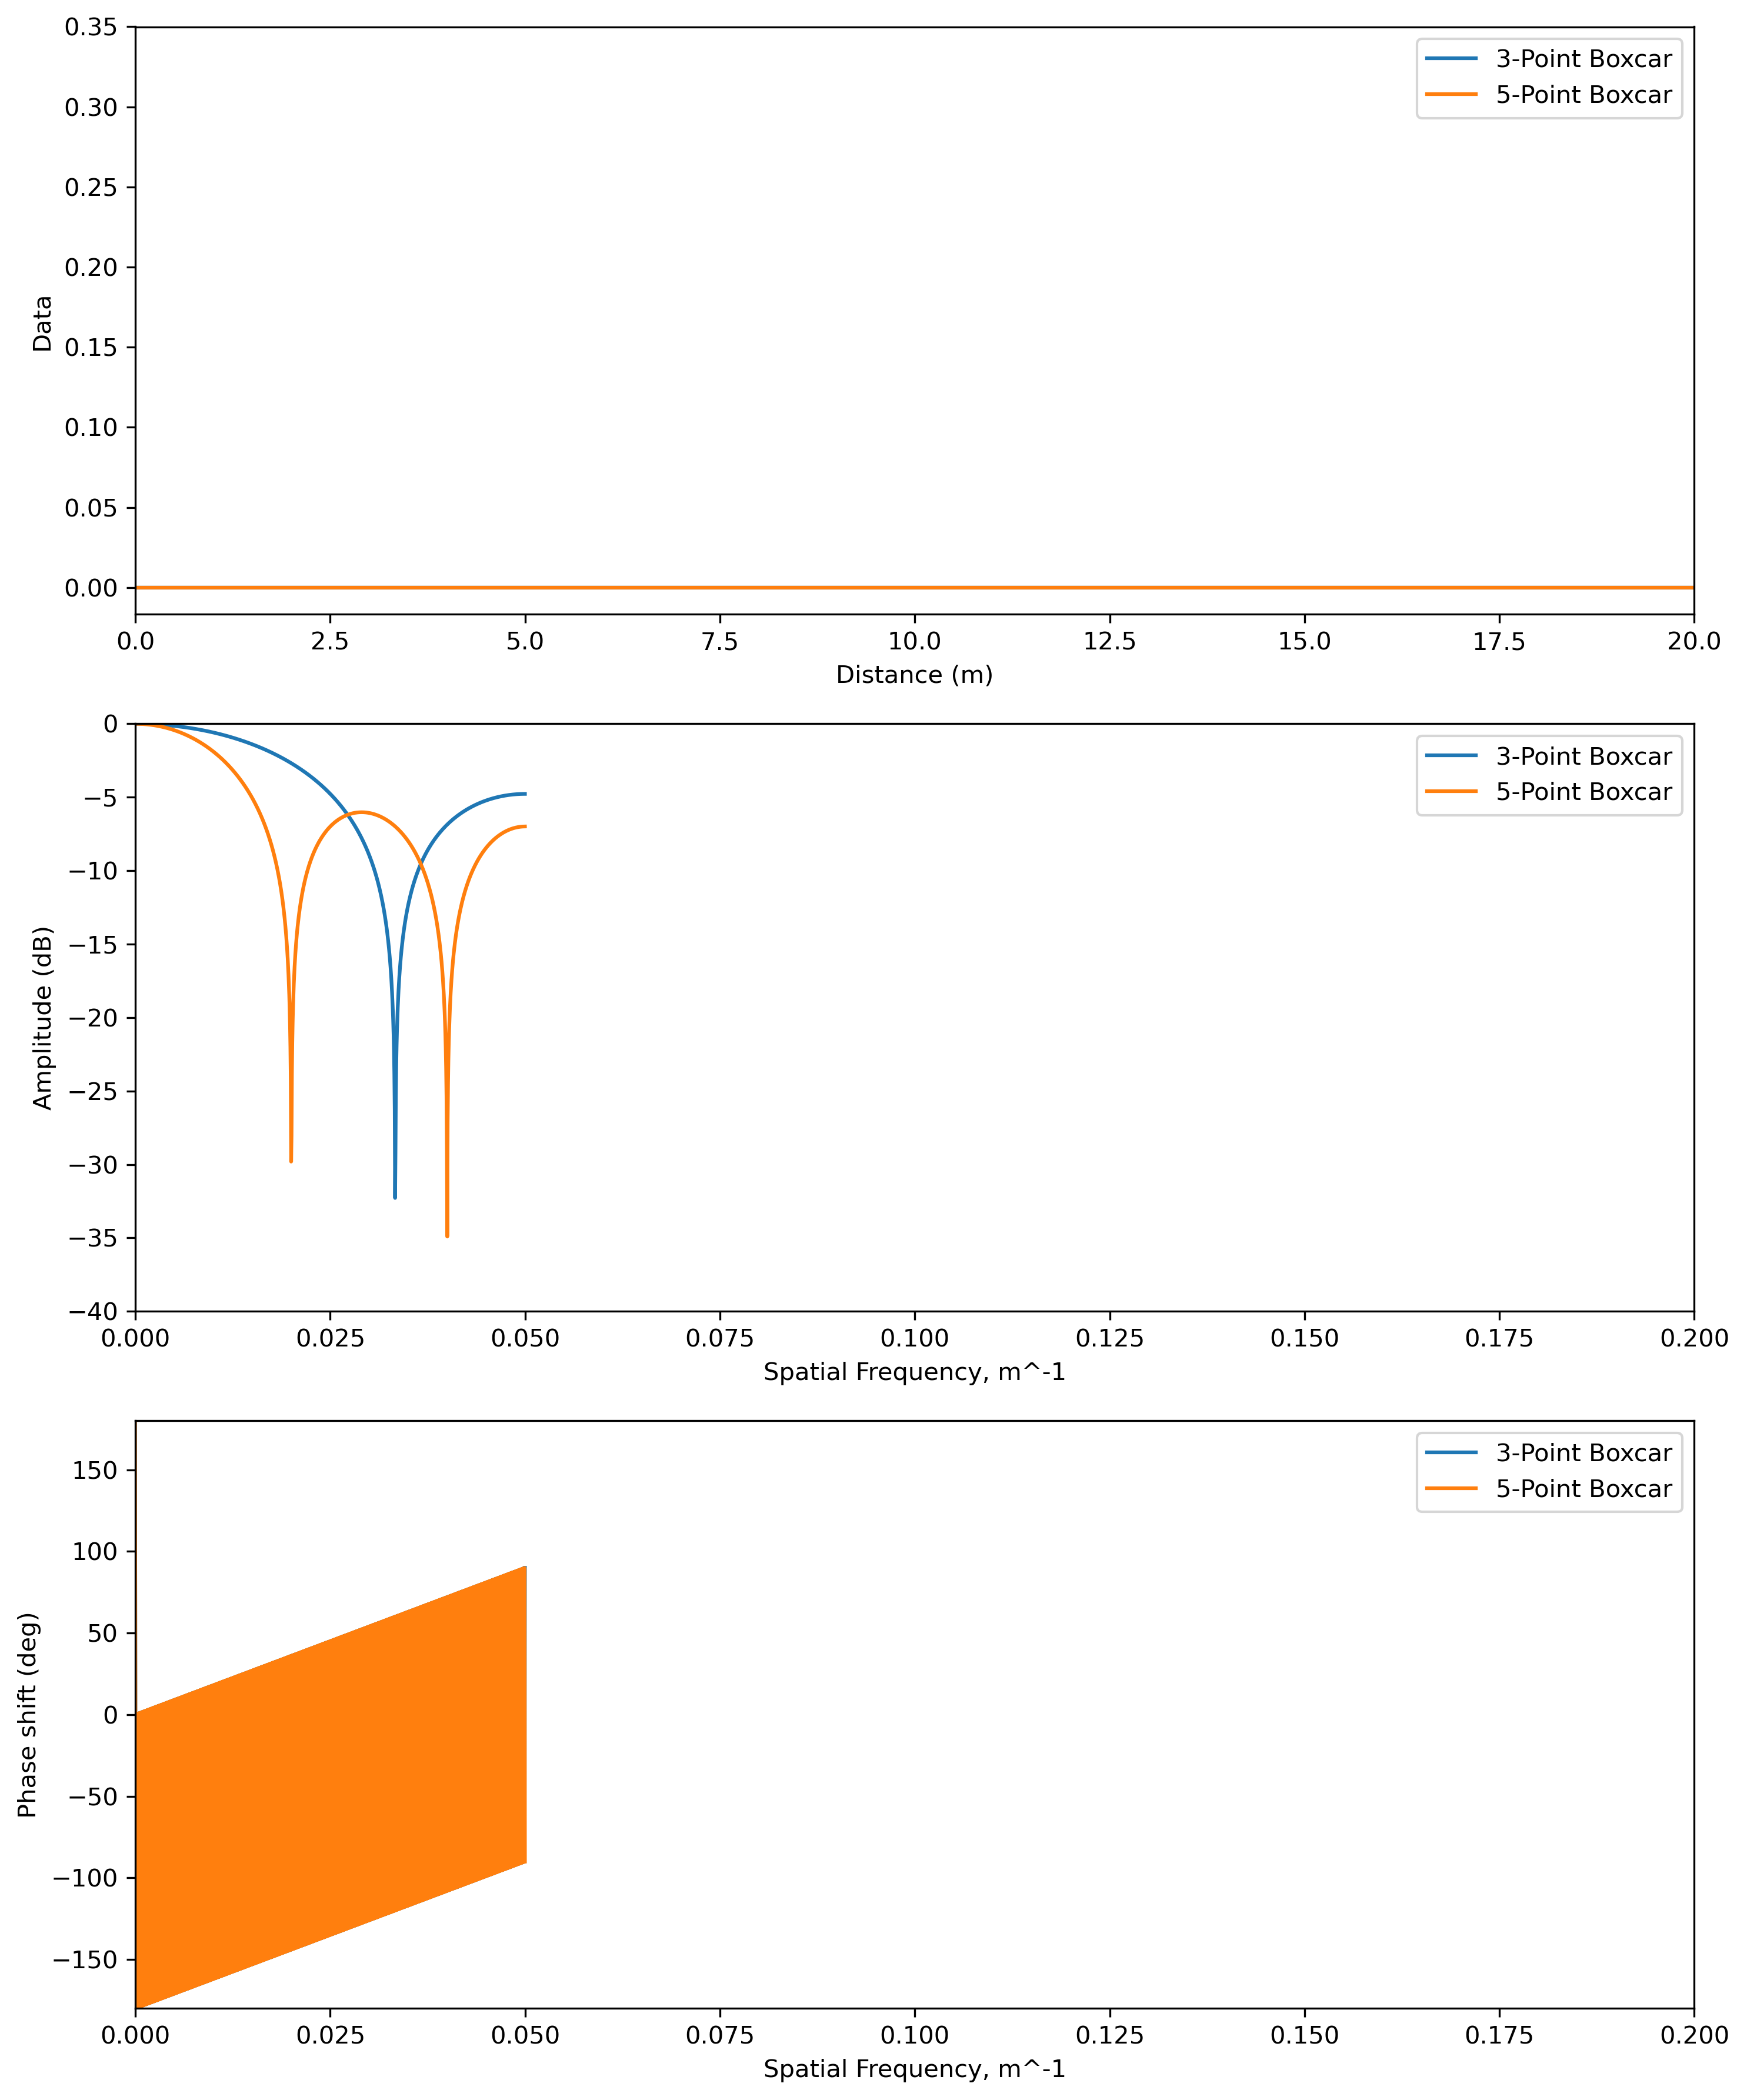

In [7]:
# 3-point
boxcar3= np.ones(3)
boxcar3/= boxcar3.sum()

# 5-point
boxcar5= np.ones(5)
boxcar5/= boxcar5.sum()

boxcars= []

for box in [boxcar3, boxcar5]:
    w= np.zeros(N)
    mid= N//2
    half= len(box)//2
    w[mid-half: mid+half+1]= box
    boxcars.append(w)
    
w_box3, w_box5= boxcars
    
labels= ['3-Point Boxcar', '5-Point Boxcar']
fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)

response_plot(boxcars, x, axes, freqs, labels=labels, wavelength= False)

axes[0].set_xlim(0, 20)    # Data axis (distance)
axes[1].set_xlim(0, 0.2)   # Frequency axis (amplitude)
axes[2].set_xlim(0, 0.2)   # Frequency axis (phase)
plt.tight_layout()

**5.** Implement and plot a 5-point Parzen (Riesz) weight function. Also show the effect of an artifical cutoff by removing the weights below 0.1.

-0.04997557401074744 0.04997557401074744


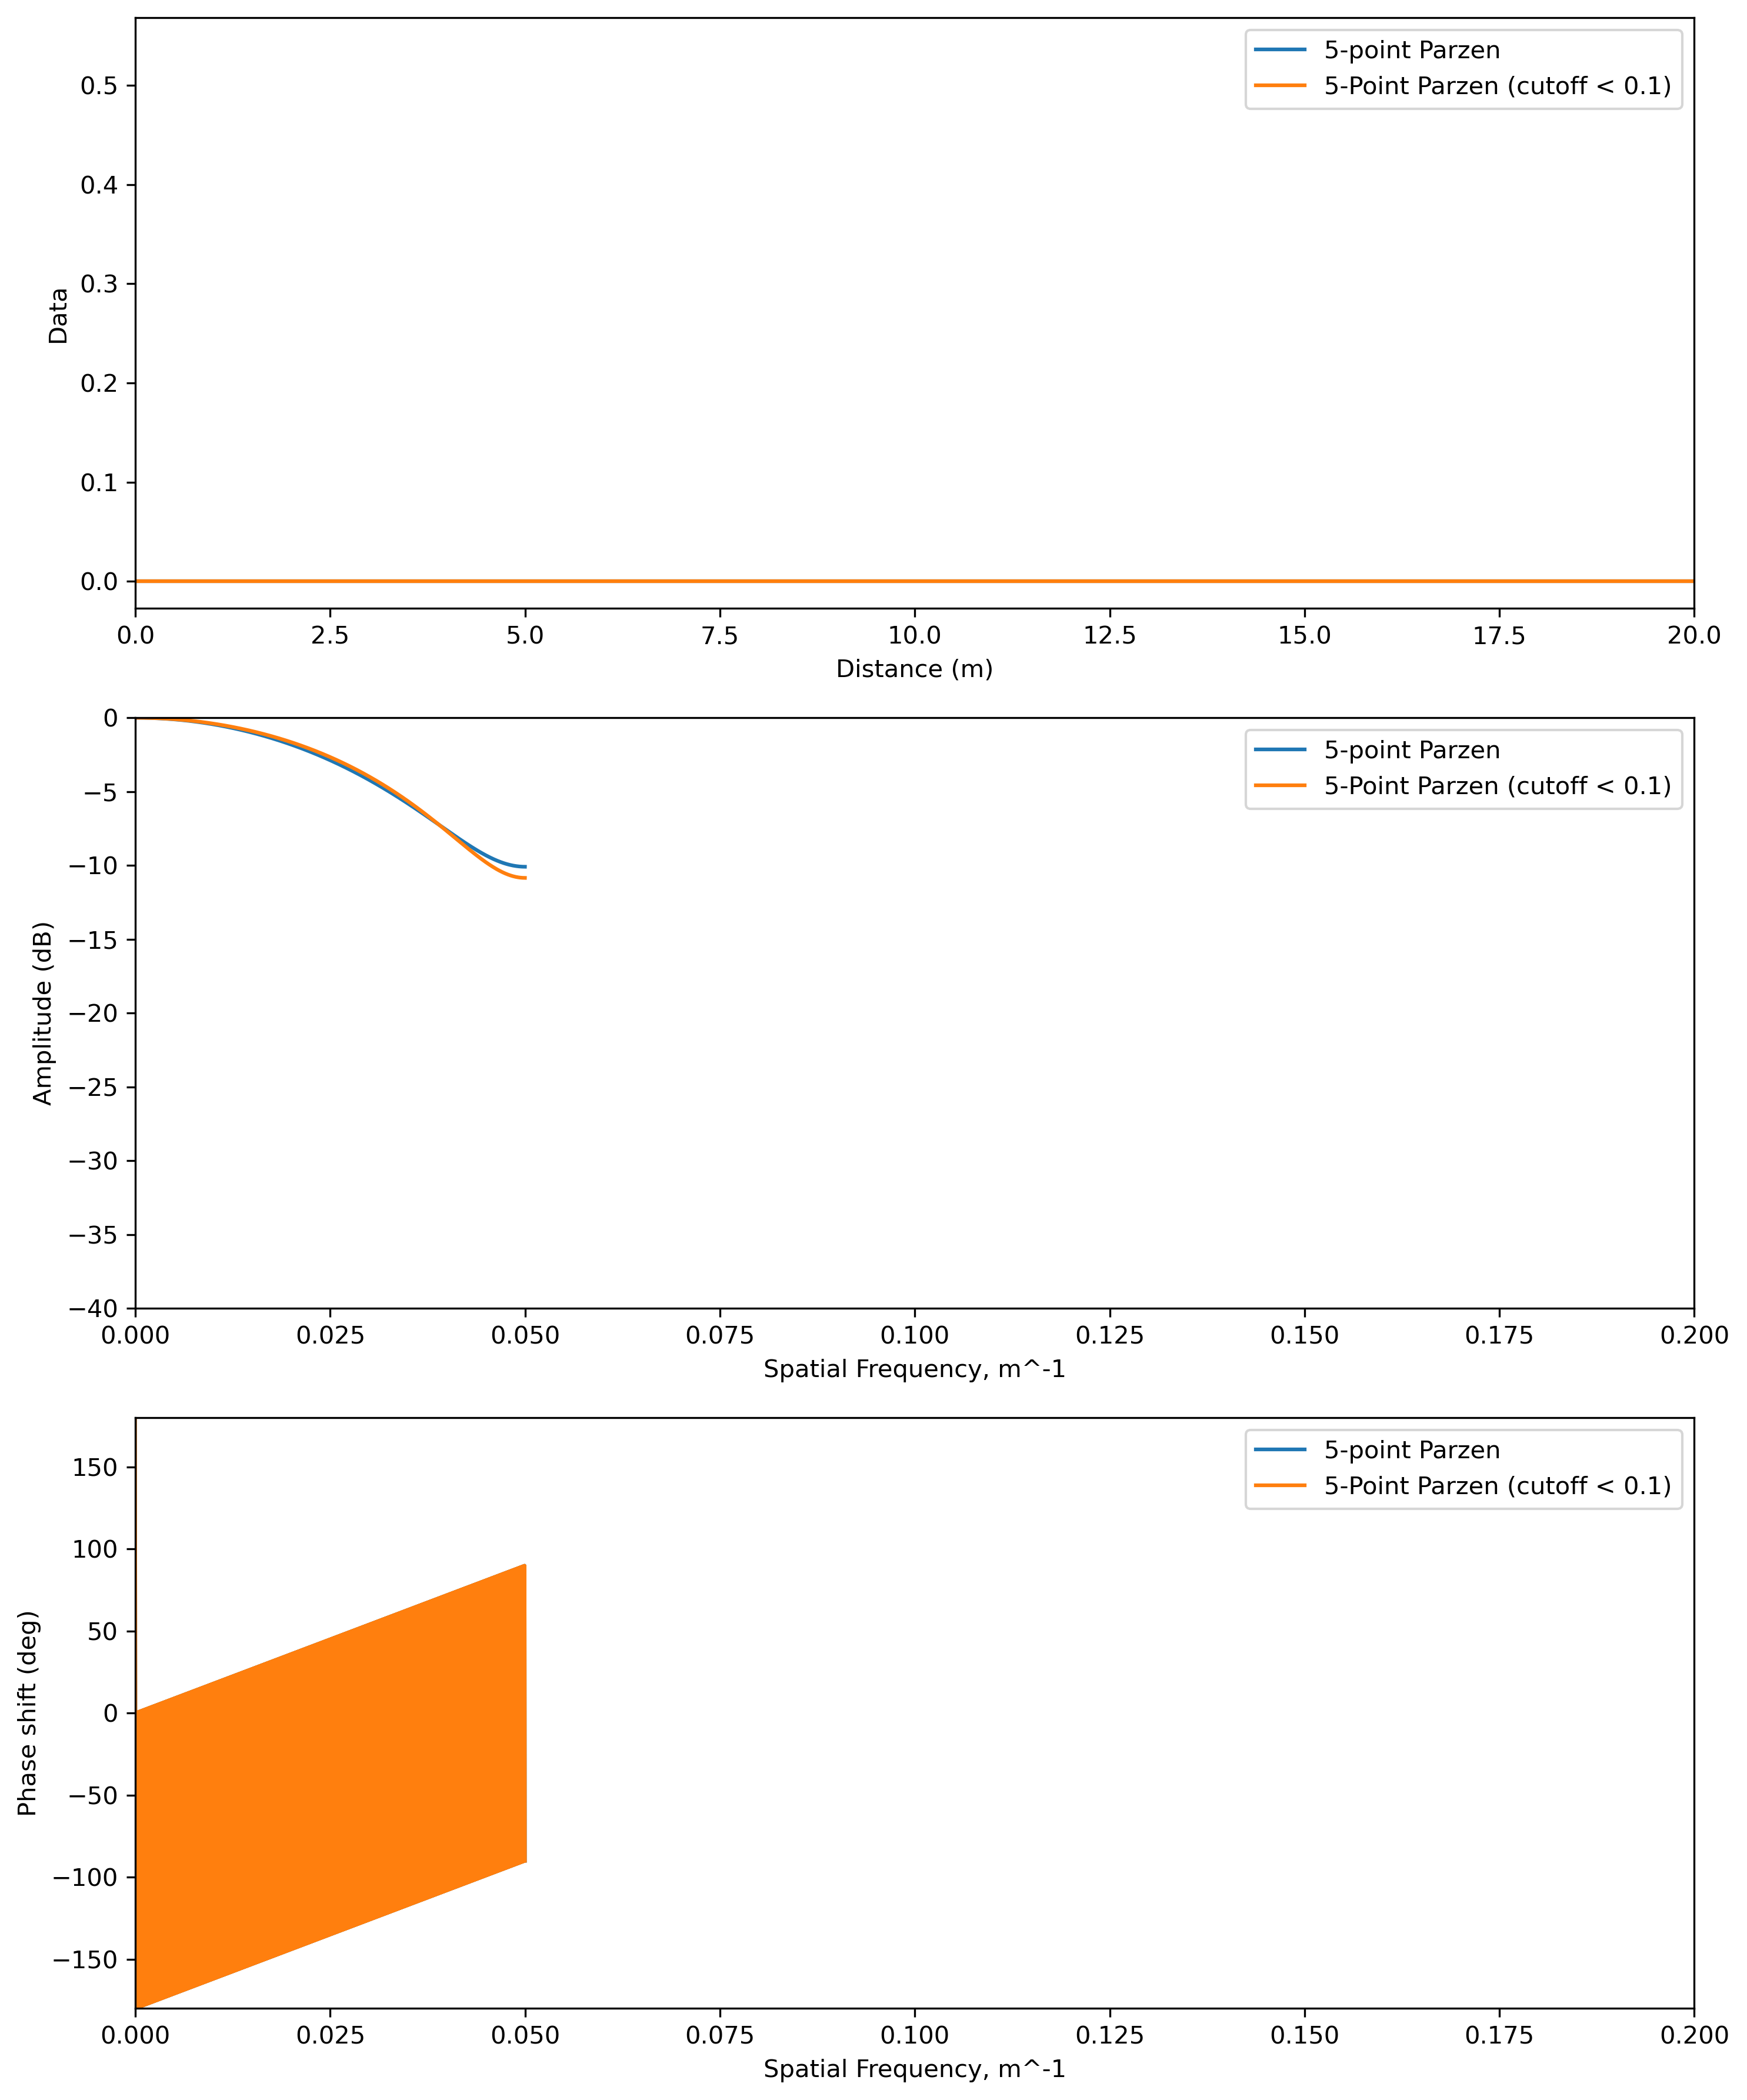

In [8]:
from scipy.signal.windows import parzen

# 5-pt Parzen window
parzen5= parzen(5)
parzen5 /= parzen5.sum() #normalize

# Center spatial grid
w_parzen= np.zeros(N)
mid= N//2
half= len(parzen5)//2
w_parzen[mid-half: mid+half+1]= parzen5

# Cutoff (weights <0.1 to 0)
w_parzen_cut= np.where(w_parzen< 0.1, 0, w_parzen)

# Normalizing cutoff
if w_parzen_cut.sum() !=0: 
    w_parzen_cut /= w_parzen_cut.sum()
    
# Storing weights and labels for plots
weights= [w_parzen, w_parzen_cut]
labels= ['5-point Parzen', '5-Point Parzen (cutoff < 0.1)']

fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)

response_plot(weights, x, axes, freqs, labels= labels, wavelength= False)

# Zooming in on region
axes[0].set_xlim(0, 20)    # Data axis (distance)
axes[1].set_xlim(0, 0.2)   # Frequency axis (amplitude)
axes[2].set_xlim(0, 0.2)   # Frequency axis (phase)
plt.tight_layout()

**6.** Implement and plot a 5-point Dolph-Chebyshev weight function with a lowest sidelobe level of 60 dB. Also show the effect of an artifical cutoff by removing the weights below 0.1.

-0.04997557401074744 0.04997557401074744


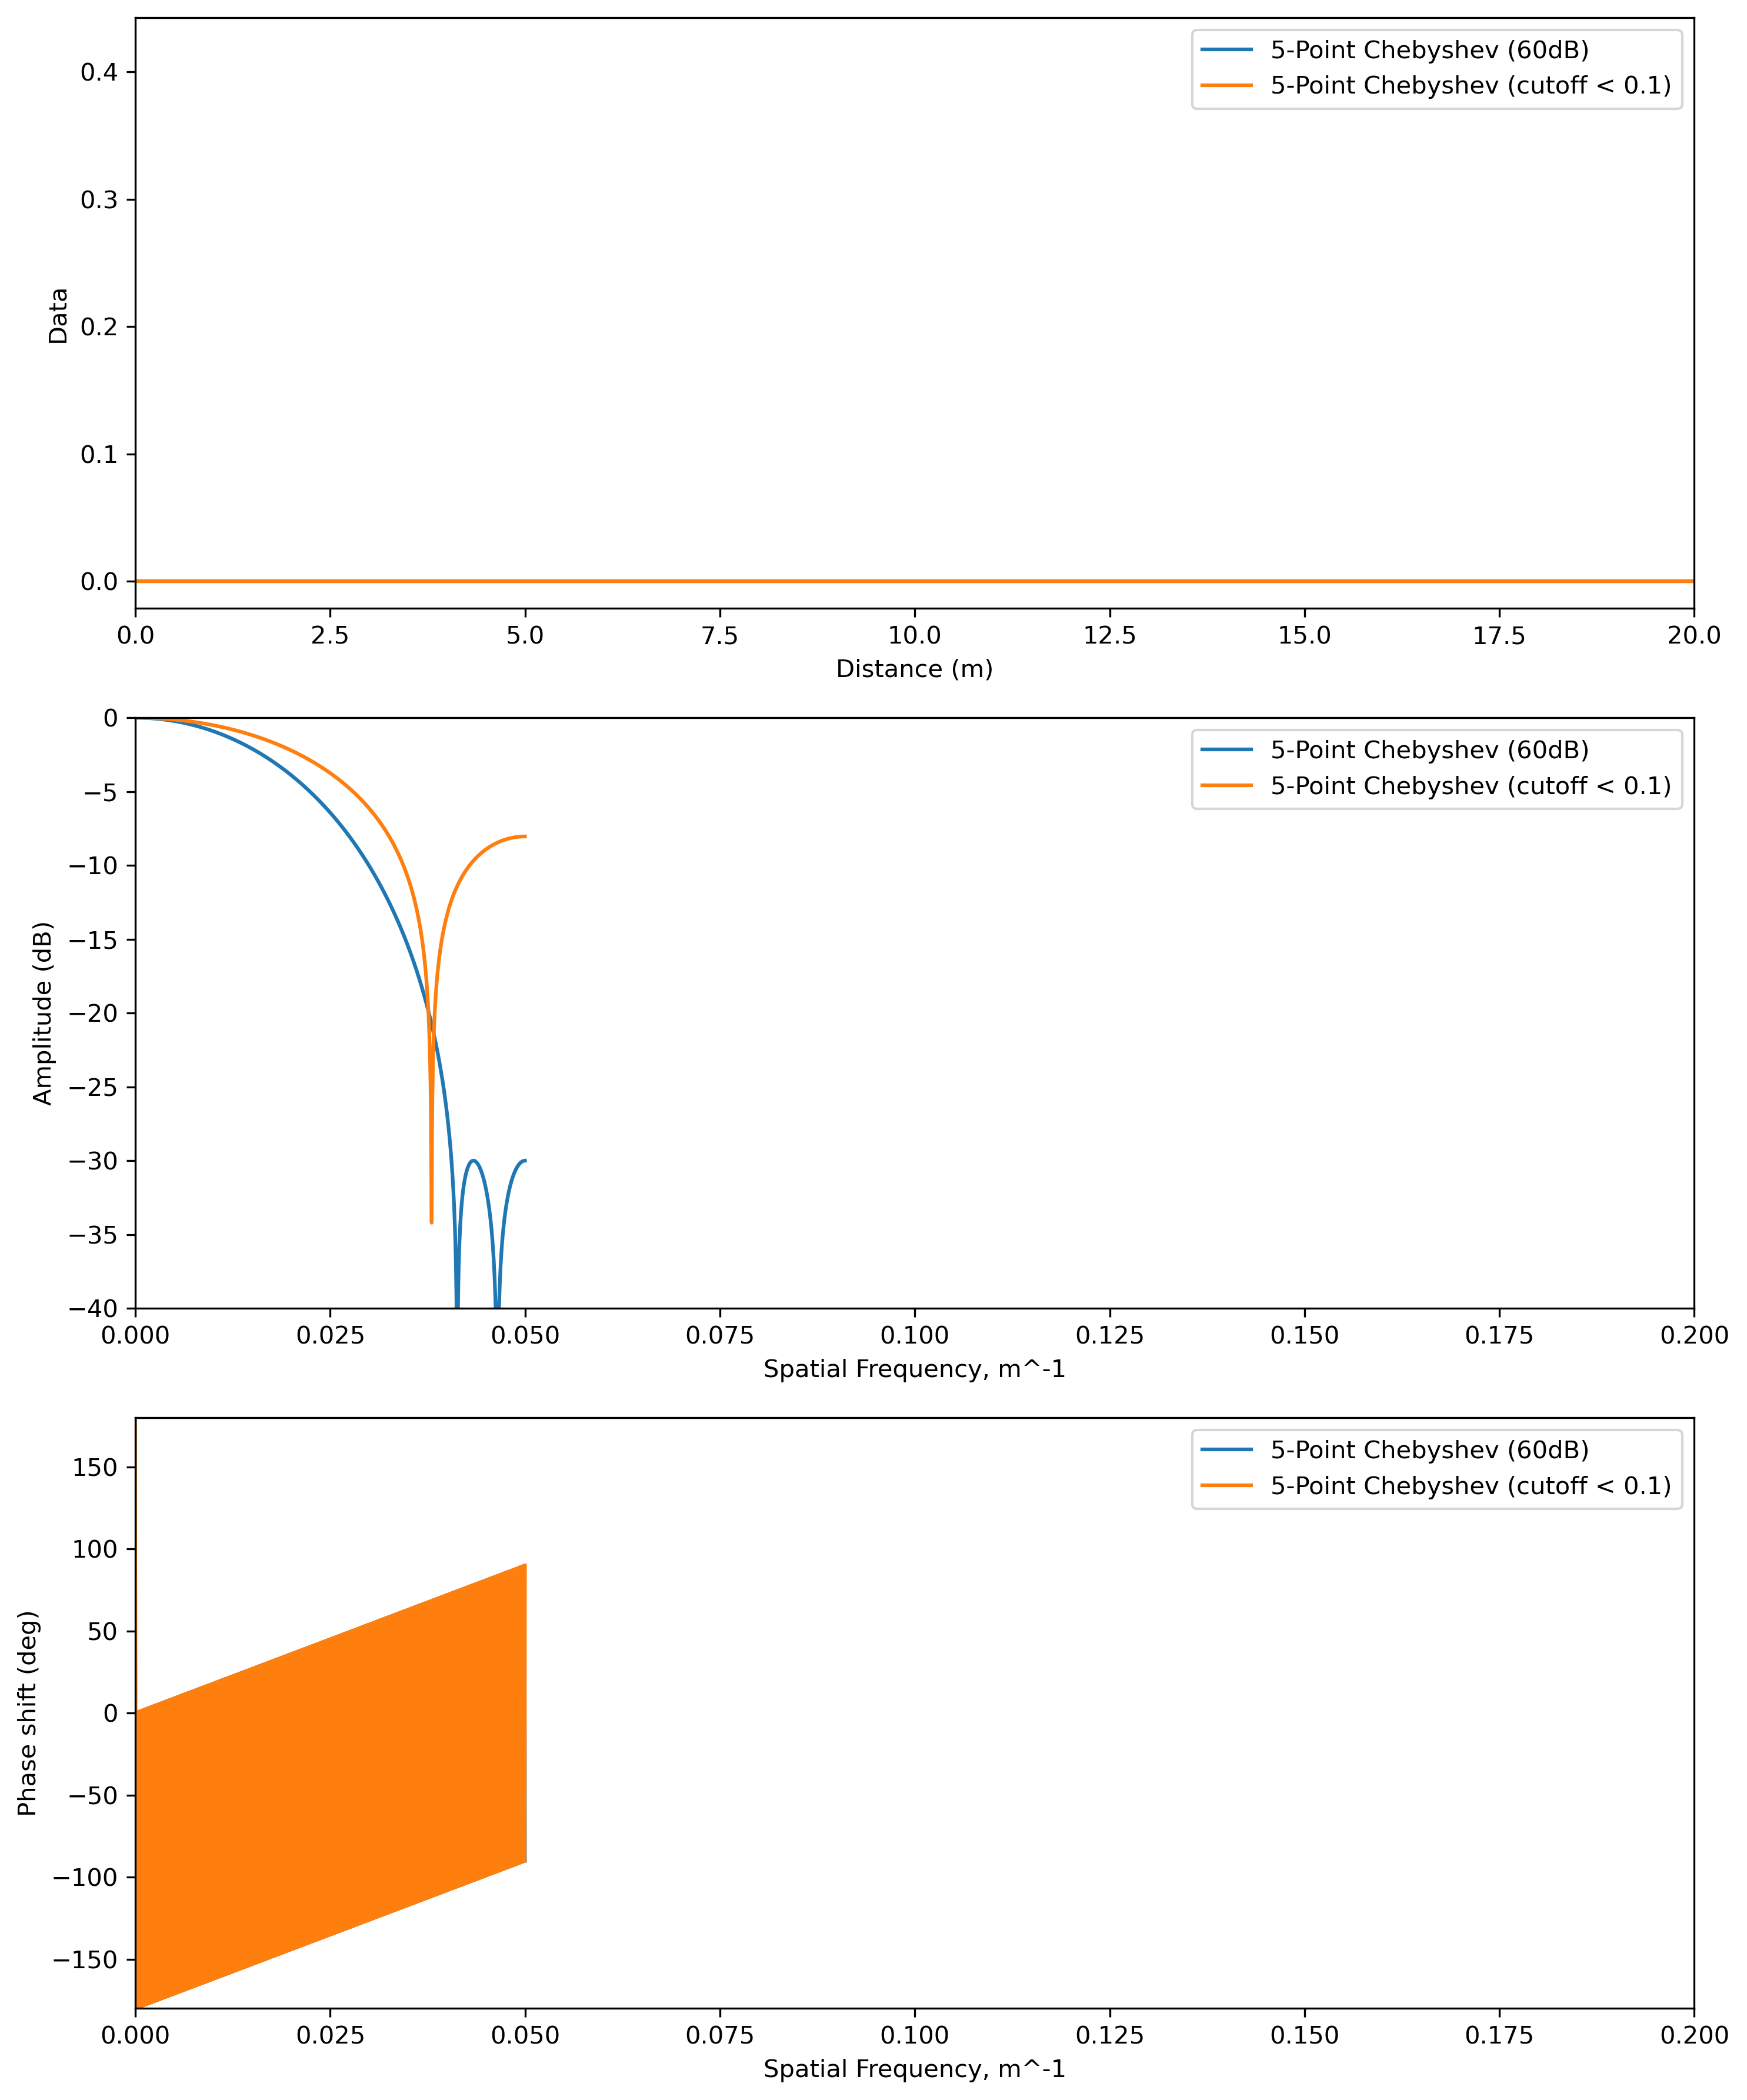

In [9]:
from scipy.signal.windows import chebwin

cheb5= chebwin(5, at= 60) # M= window length, at= sidelobe attenuation
cheb5 /= cheb5.sum() #normalizaion

# Centering
w_cheb= np.zeros(N)
mid= N//2
half= len(cheb5)//2
w_cheb[mid-half: mid+half+1]= cheb5

# Artificial cutoff 
w_cheb_cut= np.where(w_cheb< 0.1, 0, w_cheb)

# Normalizing cutoff
if w_cheb_cut.sum() !=0:
    w_cheb_cut /= w_cheb_cut.sum()
    
# Combining for plotting
weights= [w_cheb, w_cheb_cut]
labels= ['5-Point Chebyshev (60dB)', '5-Point Chebyshev (cutoff < 0.1)']

fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)

response_plot(weights, x, axes, freqs, labels= labels, wavelength= False)

# Zooming in

axes[0].set_xlim(0, 20)     # Data
axes[1].set_xlim(0, 0.2)    # Frequency
axes[2].set_xlim(0, 0.2)    # Frequency
plt.tight_layout()

**7.** Implement and plot a 7-point Blackman and a 7-point Blackman-Harris weight function. There is no need to show the effect of an artificial cutoff here.

-0.04997557401074744 0.04997557401074744


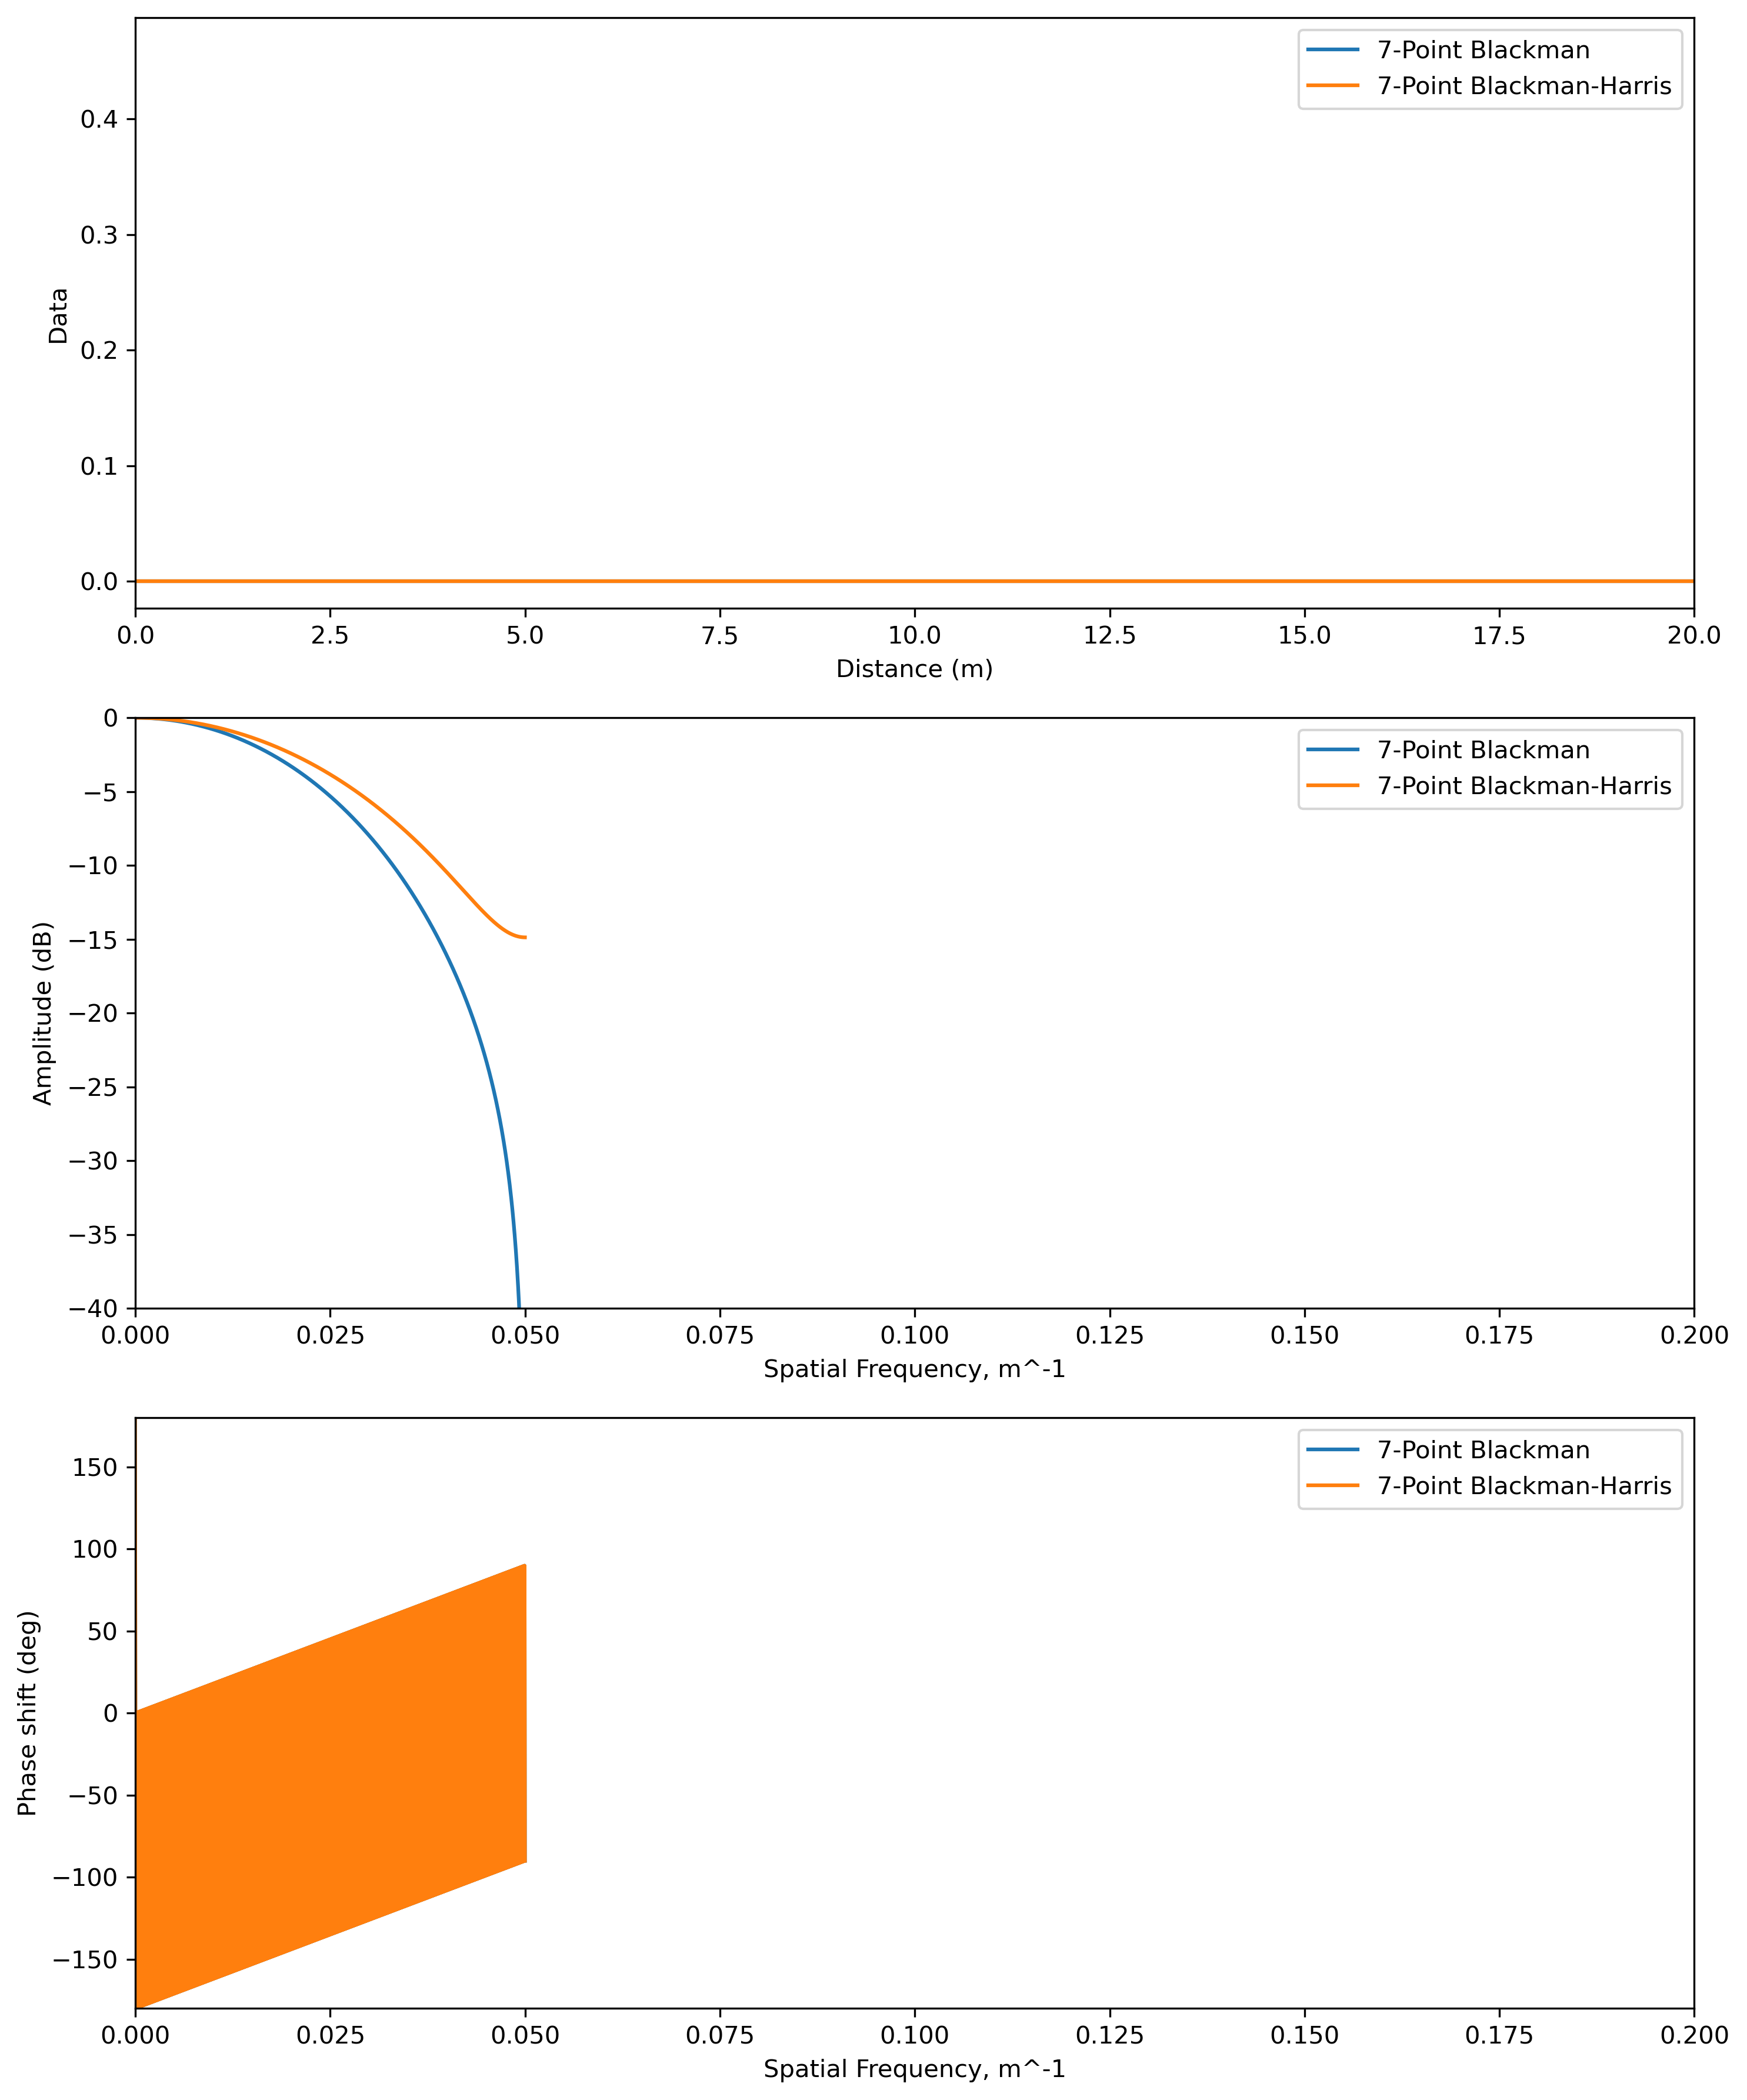

In [10]:
from scipy.signal.windows import blackmanharris, blackman

# Creating 7 point
blackman7pt= blackman(7)
blackharr7pt= blackmanharris(7)

# Normalization
blackman7pt /= blackman7pt.sum()
blackharr7pt /= blackharr7pt.sum()

# Centering in grid
def center_window(win, N):
    w= np.zeros(N)
    mid= N//2
    half= len(win)//2
    w[mid-half: mid+half+1]= win 
    return w

w_blackman= center_window(blackman7pt, N)
w_blackharr= center_window(blackharr7pt, N)

# weights and labels
weights= [w_blackman, w_blackharr]
labels= ['7-Point Blackman', '7-Point Blackman-Harris']

fig, axes= plt.subplots(3, 1, figsize= (10, 12), dpi= 300)

# Plotting in freq space
response_plot(weights, x, axes, freqs, labels= labels, wavelength= False)

# Zooming in like before
axes[0].set_xlim(0, 20)   # Data
axes[1].set_xlim(0, 0.2)  # Freq
axes[2].set_xlim(0, 0.2)  # Freq
plt.tight_layout()

**8.** 

**a.** Plot all weight functions together on the same graph, excluding those that show the effect of an artificial cutoff. Use  `dB_amp=False` to show the amplitude response in linear units. Zoom in as needed to see detail in the most interesting part of the plot.

**b.** Assume our critiera for a best analysis ranks our priorties as follows:
1. Smooth frequency response
2. Minimum amplitude at the Nyquist
3. Maximum amplitude at relatively small wavelengths just next to the Nyquist

Which weight functions are worst by these critera?

Which weight function do you regard as best, and why?

**c.** Compare the Nyquist-crossing amplitudes of the two Gaussian weight functions to the values in Koch et al. (1983), Fig. 1. How does each crossing point differ? What is the reason for the differences?

-0.04997557401074744 0.04997557401074744


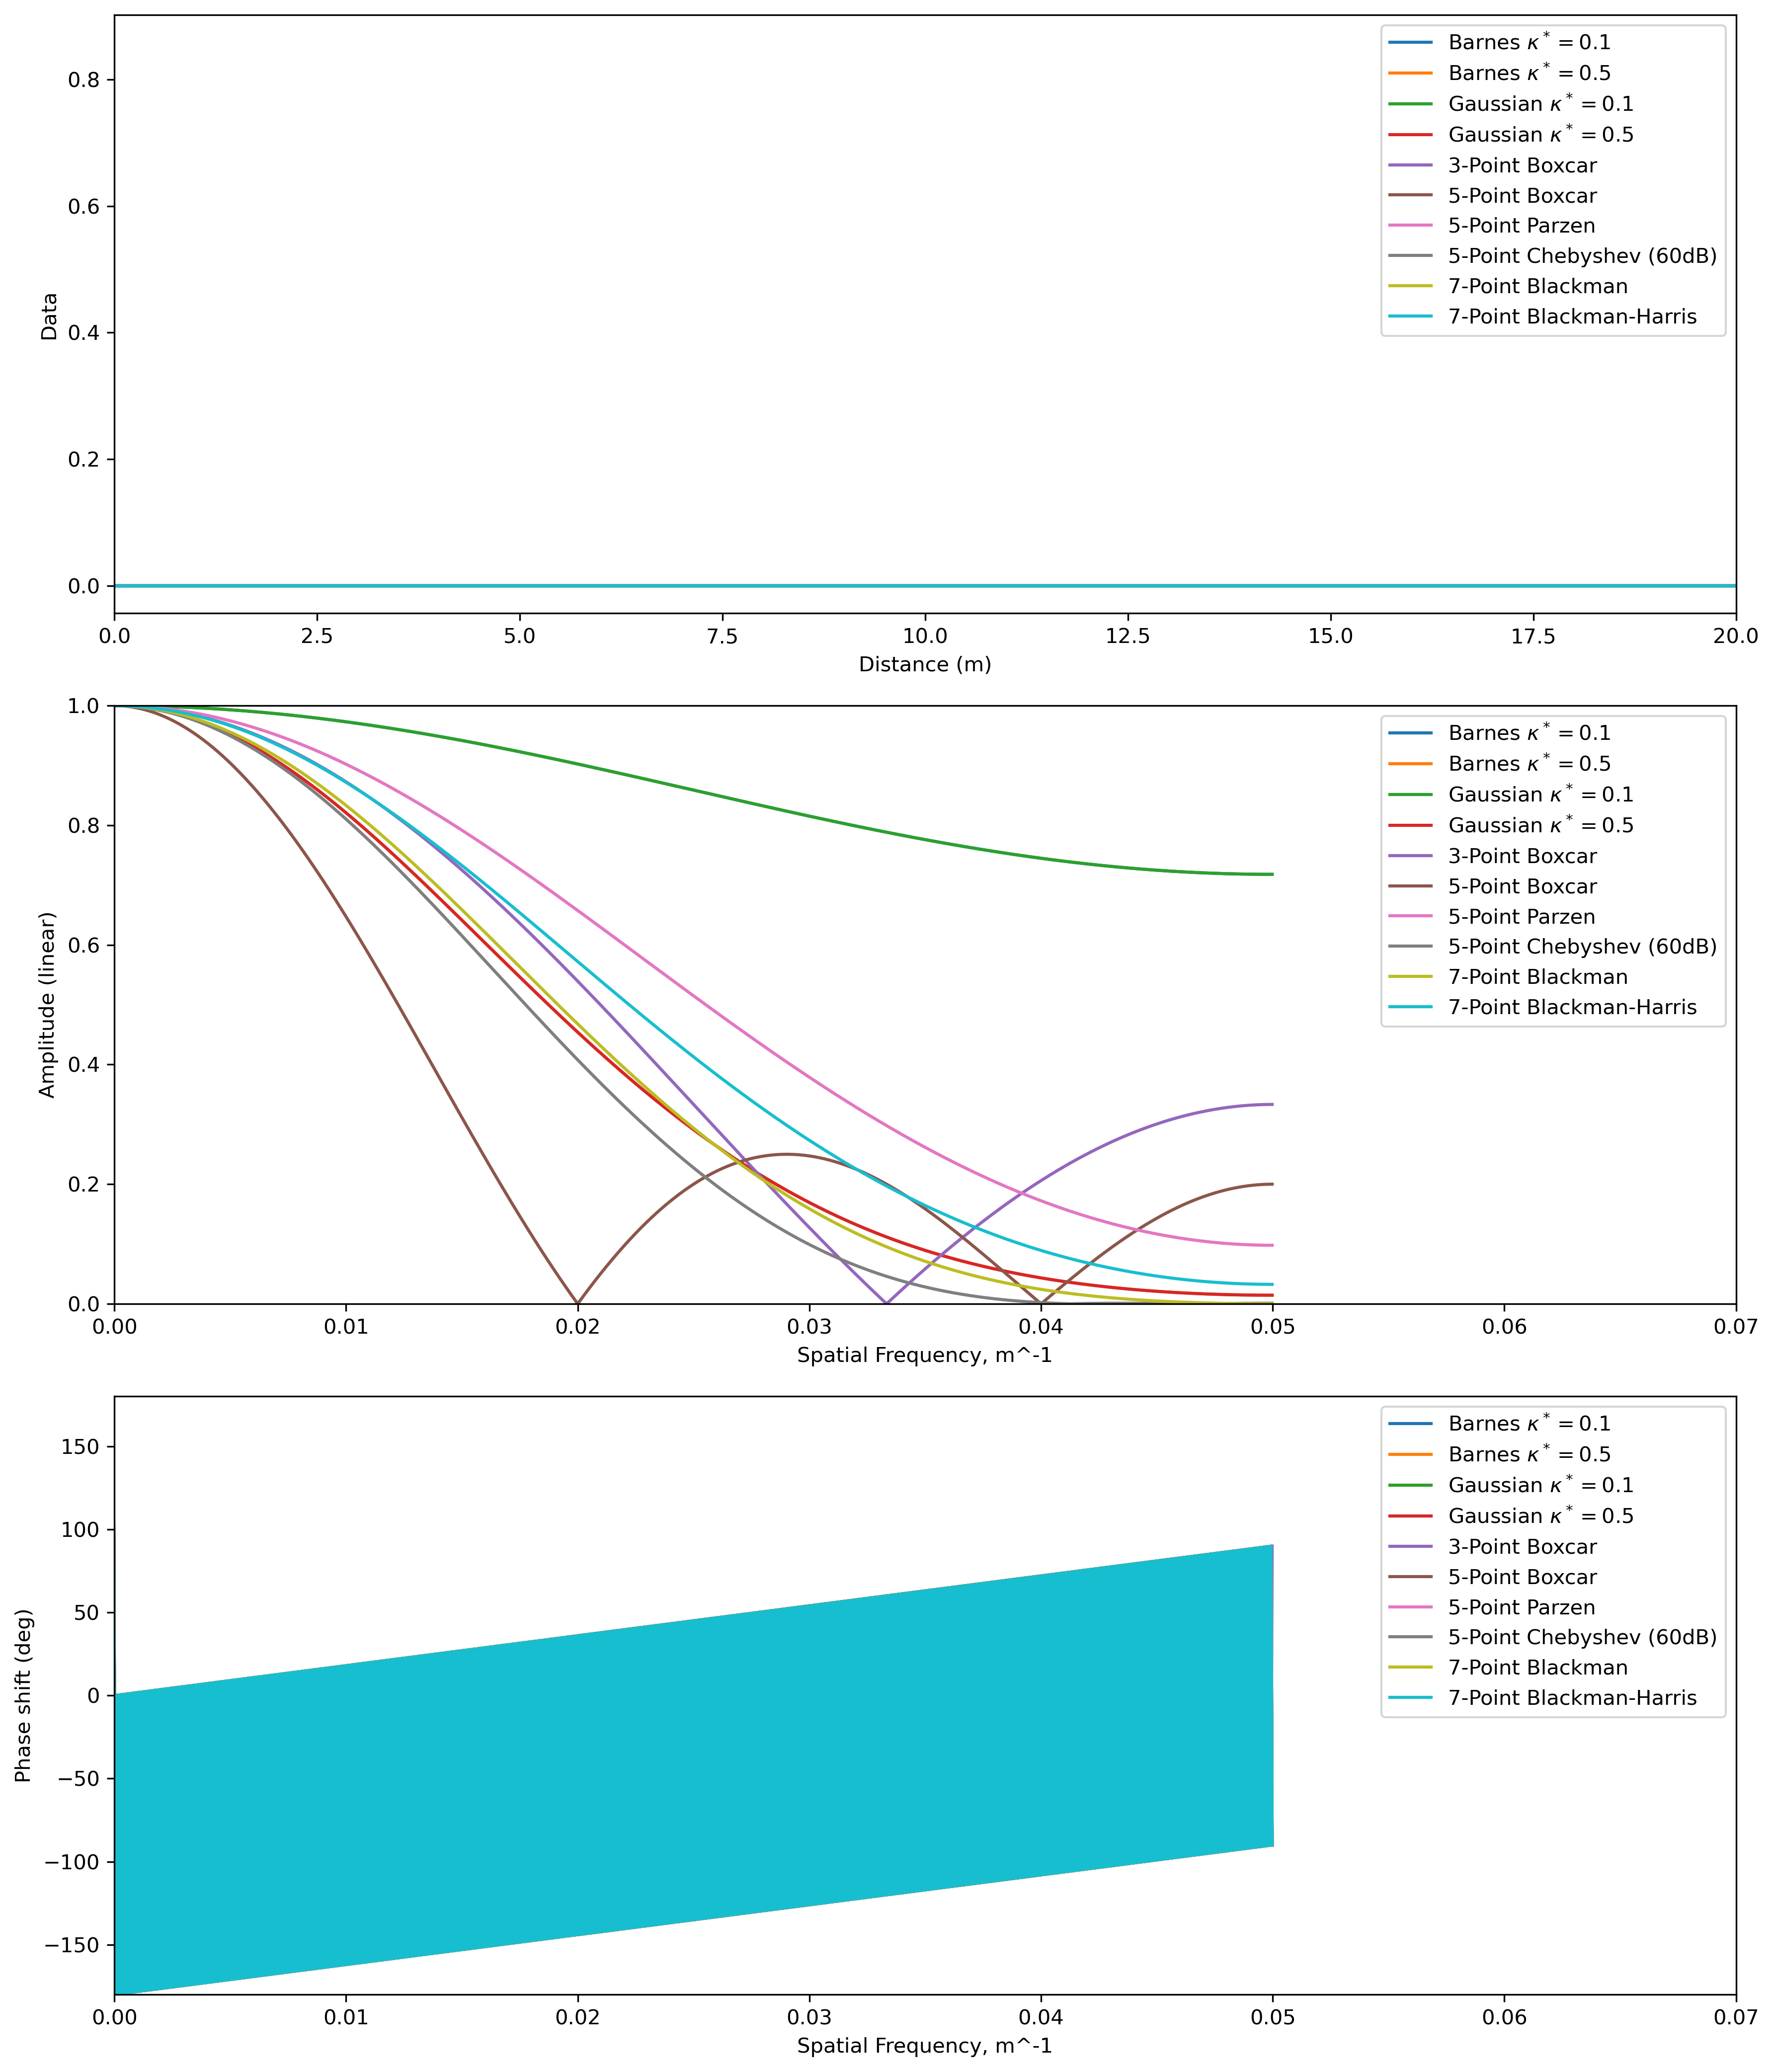

In [11]:
# a. Plotting all together except artificial cutoff
weights_all= [barnes_w01, barnes_w05, gauss_w01, gauss_w05, w_box3, w_box5,
              w_parzen, w_cheb, w_blackman, w_blackharr]

labels_all= [r'Barnes $\kappa^*= 0.1$', r'Barnes $\kappa^*= 0.5$', 
             r'Gaussian $\kappa^*= 0.1$', r'Gaussian $\kappa^*= 0.5$', 
             '3-Point Boxcar', '5-Point Boxcar', '5-Point Parzen', '5-Point Chebyshev (60dB)',
             '7-Point Blackman', '7-Point Blackman-Harris']

# Plotting
fig, axes= plt.subplots(3, 1, figsize= (12, 14), dpi= 300)

response_plot(weights_all, x, axes, freqs, labels=labels_all, wavelength=False, dB_amp=False)

# Zooming
axes[0].set_xlim(0, 20)      # spatial domain
axes[1].set_xlim(0, 0.07)    # frequency (zooming in)
axes[2].set_xlim(0, 0.07)
plt.tight_layout()

b. Based on the criteria, the weight functions that are deemed as the worst are the 3-Point Boxcar, the 5-Point Boxcar, and the artificial cutoffs. These plots have sharper edges and see the effects of sharp discontinuities. The best weight function would most likely be the 7-Point Blackman-Harris due to the smoothness and clean transitions.  

c. For a k*= 0.1 and 0.5, the analytic Barnes/Gaussian spectral response at the Nyquist wavelength (=1) is D0(1) = np.exp(-ks * np.pi^2 / lambda*^2) which gives values of 0.3727 and 0.0072, respectively. Based on Koch et al. (1983), these values are very similar to those in Fig. 1. Koch et al. (1983) assumes an infinite, continuous Gaussian kernel while these plots have finite sampling and show truncation of the Gaussian window.  

In [12]:
# Koch et al. (1983) analytic Nyquist amplitude check
import numpy as np

# Nondimensional kappa* values
kappa_vals = [0.1, 0.5]

# Nyquist nondimensional wavelength (lamb* = 1)
lambda_star = 1.0

# Analytic response from Eq. (2): D0 = exp[-k* (pi/lamb*)^2]
for ks in kappa_vals:
    D0 = np.exp(-ks * np.pi**2 / lambda_star**2)
    D0_dB = 20 * np.log10(D0)
    print(f"k*={ks:.1f}  ->  D0={D0:.4f}  ({D0_dB:.1f} dB)")

axes[1].scatter([1.0, 1.0], [dB(np.exp(-kappa_vals[0]*np.pi**2)),
                             dB(np.exp(-kappa_vals[1]*np.pi**2))],
                color=['tab:blue','tab:orange'], marker='o', s=60,
                label='Koch et al. (1983) analytic Nyquist')

axes[1].legend()
plt.tight_layout()
plt.show()

k*=0.1  ->  D0=0.3727  (-8.6 dB)
k*=0.5  ->  D0=0.0072  (-42.9 dB)


<Figure size 432x288 with 0 Axes>